# Cost Functions

Below are notes from each section of the qiskit course documentation found on this page: https://learn.qiskit.org/course/algorithm-design/cost_function

## Primitives

All physical systems, classical or quantum, can exist in different states. However, quantum systems have unique properties such as _superposition_ and _entanglement_. While classical systems can be described by their physical properties (speed or acceleration), quantum systems are described using _observables_, which are mathematical objects.

In QM, observables are represented as hermitian linear operators ($\hat{H} = \hat{H}^{\dagger}$) that act on states/kets. Given the hermitian matrix, we know the complete set of orthonormal output states of our operator. These are the eigenstates and when the operator acts on one of these states, we get a corresponding eigenvalue as the readout. 

<font color="red">Question: </font> How is this eigenvalue actually measured? For instance, given the X operator, we know our eigenstates are plus and minus and their respective eigenvalues are +1 and -1. But if we were to actually measure this state, how would we distinguish between the plus and minus states to get their eigenvalues? I know we could apply the Hadamard to get it back to a definite up or down state, but is there any way to measure the eigenvalue of the plus/minus state _without_ altering it, such as the case where you wouldn't exactly know what arbitrary state you might have but just want to measure it?

### The Sampler primitive

One way that an arbitrary state can be measured is using the sampler primitive which, given a quantum state, it obtains the probability of each possiblbe computational basis state. Thus for all $\ket{k}, k \in {0, 1, ..., 2^n -1}$, it gives back $p_k = |\bra{k}\ket{\psi}|^2$ where n is the number of qubits and k is the integer representation of any possible output binary string.

Qiskit Runtime's Sampler runs the circuit many times and measures the outputs in order to reconstruct a probability distribution based on the output binary strings. The more runs, the more accurate the results will be. However, since the number of possible outputs grow exponentially with the number of qubits, the number of runs to get an accurate distribution also grows exponentially. Therefore, the Sampler is only efficient for _sparse_ probability distributions where the target state is expressible as a linear combination of the computational basis states. Sparse means that the probability is 0 for much of the space and has sharp, non-zero probabilities in limited regions.

### The Estimator primitive

Another way that an arbitrary state can be measured is given a quantum observable, $\hat{H}$ and a state, the expected value of $\hat{H}$ can be calculated. As previously defined, this is simply the weighted average of all possible eigenvalues where the weight is the observed probability. However, we can't always calculate this because we don't always know the eigenbasis of an observable. Qiskit's Estimator solution is to take an observable and break it down into simpler, measureable observables such as the set of Pauli operators.

Any operator can be expressed as a combination of $4^n$ Pauli operators. This is because the set of Pauli operators form an orthonormal basis of the 2x2 dimensional space. Therefore, given:

$\hat{P_k} := \sigma_{k_{n-1}} \otimes ... \otimes \sigma_{k_0},  k \in Z^n  = \{0, 1, ..., 4^n -1\}$,

such that

$\hat{H} = \Sigma w_k\hat{P_k}$

for k=0 to $4^n$-1 where n is the number of qubits, $k = k_{n-1} ... k_0$ is a string of base 4 with length of n meaning that $k_l \in Z_4 = \{0, 1, 2, 3\}$, and $(\sigma_0, \sigma_1, \sigma_2, \sigma_3) := (I, X, Y, Z)$.

For example, k = 1302 means we have 4 qubits and we apply X gate to qubit 3, Z gate to qubit 2, identity to qubit 1, and Y gate to qubit 0. For 4 qubits, we have 4^4 strings to summate through and we add them all together based on their weight, $w_k$.

So for each $\hat{P_k}$, which is the kth set of n gates applied to the n qubits, the Estimator derives a new circuit, $V_k\ket{\psi}$. It runs it multiple times, measures the output state in the computational basis, and calculates the probability $p_{kj}$ of obtaining each possible output j. In order to calculate the overall expectation value of the Hamiltonian, we need to calculate the expectation value for each $\hat{P_k}$ by summing the product of each eigenvalue $\lambda_{kj}$ and its associated probability of the output j. Then, the overall expectation value is the lienar combination of all the expectation values for each $\hat{P_k}$ and their weights, $w_k$.

$<\hat{H}>_{\psi} = \Sigma w_k \Sigma p_{kj}\lambda_{kj}$

for j=0 to $2^n -1$ and k=0 to $4^n -1$.

Obviously, $4^n$ is something that grows very fast and only 4 qubits results in 256 combinations so the Estimator is only efficient is _many_ of the weights are 0. Thus, the decomposition needs to be sparse in order to be efficiently solvable.

### Guided example to calculate expectation values

We can start with the single qubit state of plus and the observable as defined below:

$\hat{H} = \begin{bmatrix}-1 & 2 \\ 2 & -1\end{bmatrix} = 2X  - Z$

with the following theoretical expectation $<H>_+ =  <+|H|+> = 2$.

Since we do not know how to measure this observable, we cannot compute its expectation value directly so we need to express it as $2<X>_+ - <Z>_+$, which is a linear combination of the X and Z gates/measurements/observables with coefficients 2 and -1. Thus, we can notice that the expectation value of the X on the plus state is 1 while the expectation value of the Z gate on the plus state is 0. 

We can understand this in 2 different ways. Firstly, we can look at it like a _transition probability_ meaning we can read it as the probability that H on plus results in plus. So because the X gate on the plus state does nothing, the resulting state always is plus state so the transition probability is 1. Secondly, we can view it as _measuring in that basis_ so measuring the plus state in the x basis is going to always result in state +/0 with eigenvalue 1. Alternatively, the Z gate will transform the plus state to the minus state so the transition probability to the plus state is always 0 and if we measure the plus state in the z-basis, it is 50% eigenvalue 1 and 50% eigenvalue -1 thus 0. Therefore 2*1 - 0 is 2.

For example, lets show how we can measure <X> and <Z> directly by measuring in the X and Z basis respectively. Since X and Z do not compute (don't share the same eigenbasis), they cannot be measured simultaneously.

Original circuit:


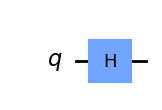

Auxiliary circuit for X


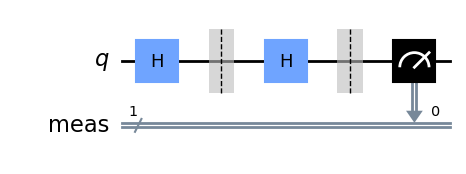

Auxiliary circuit for Z


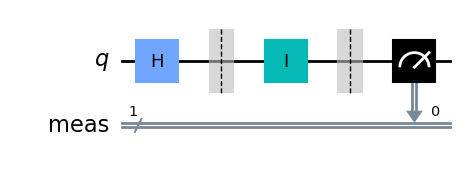

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.i(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)


print("Original circuit:")
display(original_circuit.draw("mpl"))
for (circuit, pauli) in zip(aux_circuits, H.paulis):
    print(f"Auxiliary circuit for {str(pauli)}")
    display(circuit.draw("mpl"))

We can see that our original circuit puts our qubit in the plus state by applying the Hadamard. Then our auxiliary circuit for X is going to take our state and put it in the X-basis and then measures. However, we know that the Hadamard transforms states onto the x-axis. Then our auxiliary circuit for Z doesn't need to do anything because the measurement "operator" is already by default in the z/computational basis.

Next, we can carry out the computation using the Sampler to check the results of the Estimator.

In [3]:
from qiskit.primitives import Sampler, Estimator
from qiskit.circuit.library import IGate, ZGate
import numpy as np


## SAMPLER
sampler = Sampler()
job = sampler.run(aux_circuits)
probability_dists = job.result().quasi_dists

expvals = []
for dist, pauli in zip(probability_dists, H.paulis):
    val = 0
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    else:
        Lambda = ZGate().to_matrix().real
    val += Lambda[0][0] * dist.get(0, 0)
    val += Lambda[1][1] * dist.get(1, 0)
    expvals.append(val)


print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")


## ESTIMATOR
observables = [
    *H.paulis,
    H,
]  # Note: run for individual Paulis as well as full observable H

estimator = Estimator()
job = estimator.run([original_circuit] * len(observables), observables)
estimator_expvals = job.result().values

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


### Mathematical rigor (optional)

Read through on website, not including notes here on it for now.

## Cost functions

As a reminder, the cost function is a mathematical description of the problem and the evaluation of it for a specific state gives a score of how that trial state is performing. We can consider a simple example of finding the ground state of a system, so our objective is to minimize the expectation value of the observable representing energy (Hamiltonian $\hat{H}$). The Estimator primitive can be used to evaluate the expectation value and can pass this value to an optimizer to minimize which will return a new set of optimal parameter values, $\theta$ in order to construct the next trial state. However, lets note two possibilies:

1. The ansatz does not define the solution state across the search space, meaning the subset of the quantum space that the parameterized circuit can reach does not include the solution.
2. The optimizer is unable to find the valid solution.

In general, we use a classical computer for the optimization and we call a black-box quantum oracle to evaluate our cost function.

### Example mapping to non-physical systems

One example of the type of problem one might be interested in solving is called the maximum cut problem, which is a combinatorial optimization problem. Visually, we can imagine a graph defined by a set of vertices and edges and the goal is to divide the set of vertices into two disjoint sets such that there is a maximum number of edges crossing between the two sets of vertices.

This problem is of interest because a number of other problems can be turned into Max-Cut problems such as clustering, network design, phase transitions, etc. In this specific example, we can consider a undirected graph so all edges are symmetrical ($w_{ij} = w_{ji}$) and we'll give them a value of 1. Now, if we assign a variable $x_i$ to each node/vertex within our graph that has the value of either 0 or 1 depending on which of the 2 disjoint groups it is in, we can create a cost function as follows:

$C(\vec{x}) = \displaystyle\sum_{i, j=0}^{n} w_{ij}x_i(1 - x_j)$ <br>
$C(\vec{x}) = \displaystyle\sum_{i, j=0}^{n} w_{ij}x_i - \displaystyle\sum_{i,j=0}^{n}w_{ij}x_i x_j$ <br>
$C(\vec{x}) = \displaystyle\sum_{i, j=0}^{n} w_{ij}x_i - \displaystyle\sum_{i=0}^{n}\displaystyle\sum_{j=0}^{i}2w_{ij}x_i x_j$ <br>

where we make the simplification on the last line that since the weights are symmetrical (ie the adjacency matrix is symmetrical), we don't need to loop through all i's and all j's, we can loop j up to i and count those values as double since the weights repeat.

Our goal is to maximize this cost function and to solve this on a quantum computer, we need to make this our Hamiltonian. However, the eignevalues of Pauli operators are always 1 and -1, not 0 and 1 (the $x_i$ labels of our vertices). Thus, we require the following change:

$z_i = 1 - 2x_i \rightarrow x_i = \frac{1 - z_i}{2}$

This implies:

$x_i = 0 \rightarrow z_i = 1$ <br>
$x_i = 1 \rightarrow z_i = -1$

Now we can substitute our new definition for $x_i$ into the cost function and take the negative so that we are now looking for the minima (instead of maxima) because that is natural tendency of a quantum computer (lowest energy). Thus, our final cost function is:

$-C(\vec{z}) = \displaystyle\sum_{i=0}^{n}\displaystyle\sum_{j=0}^{i} \frac{w_{ij}}{2}z_i z_j - \displaystyle\sum_{i=0}^{n}\displaystyle\sum_{j=0}^{i}\frac{w_{ij}}{2}$

In the formula above, we see that the second component is independent from what we choose our variable values to be so that is just an offset that can be precomputed ahead of time. Thus, we only need to minimize the first component. We can do that by realizing that our new variables, $z_i$ have only the values of -1 and 1 so they operate similarly to a Pauli Z gate acting on an eigenstate ($Z\ket{0} = +\ket{0}, Z\ket{1} = -\ket{1}$). We can think of $z_i$ as the Z-gate acting on qubit i in particular. So,

$z_i = Z_i = I \otimes ... \otimes Z \otimes ... \otimes I$

where Z is the ith operator. Similarly, we can consider this case:

$Z_i\ket{x_{n-1}...x_0} = z_i\ket{x_{n-1}...x_0} \rightarrow \bra{x_{n-1}...x_0}Z_i\ket{x_{n-1}...x_0} = z_i$

Thus, our Hamiltonian we can consider is the following:

$\hat{H} = \displaystyle\sum_{i=0}^n \displaystyle\sum_{j=0}^i \frac{w_{ij}}{2}Z_i Z_j$

We can look at this Hamiltonian and interpret it as measuring every pair combination of qubits in the system (of n qubits total) in the Z basis (where the measurement will result in a +1 or -1 eigenvalue) and multiplying by the pair's adjacency edge weight value. Thus, we can imagine that the quantum system will be lowest when the pairs/nodes that are connected (positive weight value) have opposite eigenvalues (because 1*1 = 1 and -1*-1=1). So if the optimal solution for $\vec{x}$ is 001011 then the quantum system in state $\ket{001011}$ would be the lowest energy state of the Hamiltonian. So this is our cost function but it is our ansatz that would need to _find_ the $\ket{001011}$ state.

## Measurement Strategy: Speed vs Accuracy

Quantum computers can be noisy which makes retrieved values non-deterministic with random fluctuations that can harm or prevent convergence of certain optimizers. Below some things to mitigate the problems.

### Error Suppression

This is a technique used to optimize and transform a circuit during compilation resulting in some classical pre-processing that adds to the overhead of the overall runtime. This works by:

* expressing the circuit using the native gates available on the quantum system
* mapping virtual qubits to physical qubits
* adding SWAPs based on connectively requirements
* optimizing 1Q and 2Q gates
* adding dynamical decoupling to idle qubits to prevent effects of decoherence

This can be added by setting the optimization_level option (recommended = 3) for primitives.

### Error Mitigation

This is a technique where users model the device noise at the time of execution, resulting in quantum pre-processing overhead for model training and classical post-processing to mitigate the errors in the raw results by using the generated model. I think this is kind of like getting a baseline or measuring the inherent bias of the device and then correcting for that bias in the results of the circuit. 

This can be done using Qiskit Runtime primitive's resilience_level option.

### Twirled readout error extinction (T-REx)

This technique reduces noise during the process of quantum measurement and is very general and effective to use.

###  Zero noise extrapolation

This technique works by amplifying the noise in a circuit and modeling the measurements for different levels of noise to then extrapolate the results back to a zero noise limit.

### Probabilistic error cancellation

PEC is not as general as a method and has exponential sampling overhead but when it works, it works great. It does so by sampling a collection of circuits and thus mimics a noise inverting channel to cancel out the noise in a desired computation.

### Using Qiskit Runtime's mitigation and suppression options

Trade-offs for the different error mitigation and supression techniques can be found on the webpage. Overall, these can be set using the primitive options.